<a href="https://colab.research.google.com/github/sorrri/plotters/blob/main/LH_Made_Cookies_fin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
# 한글 폰트
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 20 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 1s (7,038 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 124926 files and dire

In [1]:
from google.colab import files
uploaded = files.upload()

Saving 1.성남시_거주인구.csv to 1.성남시_거주인구.csv
Saving 2.성남시_상권정보.csv to 2.성남시_상권정보.csv
Saving 3.성남시_상가개폐업.csv to 3.성남시_상가개폐업.csv
Saving 4.성남시_표제부.csv to 4.성남시_표제부.csv
Saving 5.성남시_층별개요.csv to 5.성남시_층별개요.csv
Saving 7.성남시_지식산업센터.csv to 7.성남시_지식산업센터.csv
Saving 8.성남시_개별공시지가.csv to 8.성남시_개별공시지가.csv
Saving 9.성남시_버스정류장.csv to 9.성남시_버스정류장.csv
Saving 10.성남시_지하철역.csv to 10.성남시_지하철역.csv


In [1]:
# 경로 설정
file_paths = {
    "거주인구": "/content/1.성남시_거주인구.csv",
    "상권정보": "/content/2.성남시_상권정보.csv",
    "상가개폐업": "/content/3.성남시_상가개폐업.csv",
    "층별개요": "/content/5.성남시_층별개요.csv",
    "지식산업센터": "/content/7.성남시_지식산업센터.csv",
    "개별공시지가": "/content/8.성남시_개별공시지가.csv",
    "버스정류장": "/content/9.성남시_버스정류장.csv",
    "지하철역": "/content/10.성남시_지하철역.csv"
}

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
plt.figure(figsize=(15, 10))
plt.rc('font', family='NanumBarunGothic')

import os
import gc
import pandas as pd
import geopandas as gpd
import numpy as np
from shapely.geometry import Point
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, StackingRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.preprocessing import RobustScaler
from scipy.spatial import cKDTree
from xgboost import XGBRegressor
import lightgbm as lgb
import tensorflow as tf

<Figure size 1500x1000 with 0 Axes>

# **데이터 전처리 및 거리 계산**

In [3]:
# 데이터 로드, 전처리
df_population = pd.read_csv(file_paths["거주인구"], encoding="utf-8-sig").fillna(0)
df_population["total_population"] = df_population.iloc[:, 2:].sum(axis=1)
df_population = df_population.groupby("gid")["total_population"].sum().reset_index()

df_land_value = pd.read_csv(file_paths["개별공시지가"], encoding="utf-8-sig").fillna(0)
df_land_value_avg = df_land_value.groupby("bjd_nm")["land_value"].mean().reset_index()
df_land_value_avg["land_value_change"] = df_land_value_avg["land_value"].pct_change().fillna(0)

df_floors = pd.read_csv(file_paths["층별개요"], encoding="utf-8-sig", low_memory=False).fillna(0)
df_floors_grouped = df_floors.groupby("plat_plc")["flr_num"].max().reset_index()

df_shop = pd.read_csv(file_paths["상가개폐업"], encoding="utf-8-sig").fillna(0)
df_shop_grouped = df_shop.groupby("addr")["biz_stts_nm"].count().reset_index()
df_shop_grouped.rename(columns={"biz_stts_nm": "num_business_changes"}, inplace=True)

def convert_to_gdf(df, lon_col, lat_col):
    df = df.dropna(subset=[lon_col, lat_col])
    df["geometry"] = [Point(xy) for xy in zip(df[lon_col], df[lat_col])]
    return gpd.GeoDataFrame(df, geometry="geometry", crs="EPSG:4326")

gdf_industrial = convert_to_gdf(pd.read_csv(file_paths["지식산업센터"], encoding="utf-8-sig"), "lon", "lat")
gdf_industrial = gdf_industrial.merge(df_land_value_avg, left_on="addr", right_on="bjd_nm", how="left")
gdf_industrial = gdf_industrial.merge(df_population, left_on="addr", right_on="gid", how="left")
gdf_industrial = gdf_industrial.merge(df_floors_grouped, left_on="addr", right_on="plat_plc", how="left")
gdf_industrial = gdf_industrial.merge(df_shop_grouped, left_on="addr", right_on="addr", how="left")

In [4]:
# 거리 계산, 공간 분석
gdf_bus = convert_to_gdf(pd.read_csv(file_paths["버스정류장"], encoding="utf-8-sig"), "lon", "lat")
gdf_subway = convert_to_gdf(pd.read_csv(file_paths["지하철역"], encoding="utf-8-sig"), "lon", "lat")

def calculate_nearest_distance(source_gdf, target_gdf):
    return [target_gdf.distance(pt).min() * 111 for pt in source_gdf.geometry]

gdf_industrial["bus_distance_km"] = calculate_nearest_distance(gdf_industrial, gdf_bus)
gdf_industrial["subway_distance_km"] = calculate_nearest_distance(gdf_industrial, gdf_subway)

def count_nearby_stations(center_gdf, station_gdf, radius=1000):
    tree = cKDTree(list(zip(station_gdf.geometry.x, station_gdf.geometry.y)))
    counts = [len(tree.query_ball_point((pt.x, pt.y), radius)) for pt in center_gdf.geometry]
    return counts

gdf_industrial["bus_station_count"] = count_nearby_stations(gdf_industrial, gdf_bus)
gdf_industrial["subway_station_count"] = count_nearby_stations(gdf_industrial, gdf_subway)

gdf_industrial["vacancy_rate"] = 1 - (gdf_industrial["cpn_in_2406"] / gdf_industrial["tot_cpn"])
gdf_industrial.fillna(0, inplace=True)

<ipython-input-4-b962fb8b4078>:6: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  return [target_gdf.distance(pt).min() * 111 for pt in source_gdf.geometry]
<ipython-input-4-b962fb8b4078>:6: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  return [target_gdf.distance(pt).min() * 111 for pt in source_gdf.geometry]
<ipython-input-4-b962fb8b4078>:20: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  gdf_industrial.fillna(0, inplace=True)


# **가설별 분석 및 시각화**

Text(0, 0.5, '공실률')

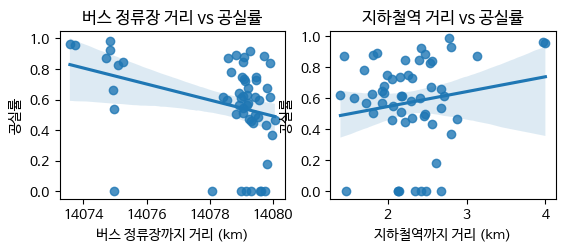

In [5]:
# 대중교통 접근성과 공실률 관계
plt.subplot(2,2,1)
sns.regplot(x=gdf_industrial["bus_distance_km"], y=gdf_industrial["vacancy_rate"])
plt.title("버스 정류장 거리 vs 공실률")
plt.xlabel("버스 정류장까지 거리 (km)")
plt.ylabel("공실률")

plt.subplot(2,2,2)
sns.regplot(x=gdf_industrial["subway_distance_km"], y=gdf_industrial["vacancy_rate"])
plt.title("지하철역 거리 vs 공실률")
plt.xlabel("지하철역까지 거리 (km)")
plt.ylabel("공실률")

Text(0, 0.5, '공실률')

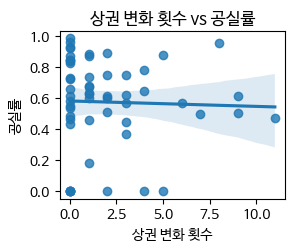

In [6]:
# 상권 개수와 공실률 관계
plt.subplot(2,2,3)
sns.regplot(x=gdf_industrial["num_business_changes"], y=gdf_industrial["vacancy_rate"])
plt.title("상권 변화 횟수 vs 공실률")
plt.xlabel("상권 변화 횟수")
plt.ylabel("공실률")

<ipython-input-7-2fd51b92ddd1>:8: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumBarunGothic.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumBarunGothic.
  fig.canvas.print_figure(bytes_io, **kw)


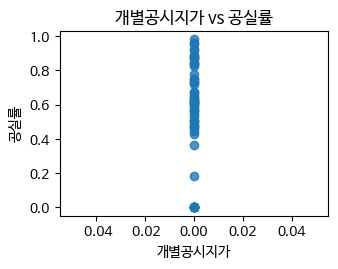

In [7]:
# 개별공시지가와 공실률 관계
plt.subplot(2,2,4)
sns.regplot(x=gdf_industrial["land_value"], y=gdf_industrial["vacancy_rate"])
plt.title("개별공시지가 vs 공실률")
plt.xlabel("개별공시지가")
plt.ylabel("공실률")

plt.tight_layout()
plt.show()

In [8]:
# 상관계수 계산
bus_corr, _ = pearsonr(gdf_industrial["bus_distance_km"], gdf_industrial["vacancy_rate"])
subway_corr, _ = pearsonr(gdf_industrial["subway_distance_km"], gdf_industrial["vacancy_rate"])
business_corr, _ = pearsonr(gdf_industrial["num_business_changes"], gdf_industrial["vacancy_rate"])
land_corr, _ = pearsonr(gdf_industrial["land_value"], gdf_industrial["vacancy_rate"])

print(f"버스 정류장 거리 vs 공실률 상관계수: {bus_corr:.3f}")
print(f"지하철역 거리 vs 공실률 상관계수: {subway_corr:.3f}")
print(f"상권 변화 횟수 vs 공실률 상관계수: {business_corr:.3f}")
print(f"개별공시지가 vs 공실률 상관계수: {land_corr:.3f}")

버스 정류장 거리 vs 공실률 상관계수: -0.330
지하철역 거리 vs 공실률 상관계수: 0.167
상권 변화 횟수 vs 공실률 상관계수: -0.032
개별공시지가 vs 공실률 상관계수: nan


<ipython-input-8-d5dbfc0d5b41>:5: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  land_corr, _ = pearsonr(gdf_industrial["land_value"], gdf_industrial["vacancy_rate"])


# **머신러닝 모델을 활용한 공실률 예측 가능성 검증**

In [9]:
# TensorFlow retracing 방지
@tf.function(reduce_retracing=True)
def safe_predict(model, data):
    return model.predict(data, batch_size=32)

In [10]:
# 새로운 Feature 추가
gdf_industrial["log_bus_distance"] = np.log1p(gdf_industrial["bus_distance_km"])
gdf_industrial["log_subway_distance"] = np.log1p(gdf_industrial["subway_distance_km"])
gdf_industrial["transport_score"] = gdf_industrial["bus_station_count"] + gdf_industrial["subway_station_count"]

In [11]:
# XGBoost & RandomForest 기반
gdf_industrial = gdf_industrial.select_dtypes(include=[np.number])

xgb_selector = XGBRegressor(n_estimators=500, learning_rate=0.02, max_depth=6, random_state=42)
xgb_selector.fit(gdf_industrial.drop(columns=["vacancy_rate"]), gdf_industrial["vacancy_rate"])
feature_importances = pd.Series(xgb_selector.feature_importances_, index=gdf_industrial.columns.drop("vacancy_rate"))
selected_features = feature_importances.nlargest(5).index.tolist()

scaler = RobustScaler()
X_scaled = scaler.fit_transform(gdf_industrial[selected_features])
X_train, X_test, y_train, y_test = train_test_split(X_scaled, gdf_industrial["vacancy_rate"], test_size=0.2, random_state=42)

In [12]:
# Stacking Model 최적화
stacking_model = StackingRegressor(
    estimators=[
        ("rf", RandomForestRegressor(n_estimators=500, max_depth=6, random_state=42)),
        ("xgb", XGBRegressor(n_estimators=500, learning_rate=0.02, max_depth=6, random_state=42)),
        ("lgb", lgb.LGBMRegressor(n_estimators=500, learning_rate=0.02, max_depth=6, random_state=42))
    ],
    final_estimator=Ridge(alpha=1.0)
)
stacking_model.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001085 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 64
[LightGBM] [Info] Number of data points in the train set: 44, number of used features: 4
[LightGBM] [Info] Start training from score 0.564526
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


StackingRegressor(estimators=[('rf',
                               RandomForestRegressor(max_depth=6,
                                                     n_estimators=500,
                                                     random_state=42)),
                              ('xgb',
                               XGBRegressor(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            gro...
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=6,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=500, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=42, ...)),
                              ('lgb',
                               LGBMRegressor(learning_rate=0.02, max_depth=6,
                                             n_estimators=500,
                                             random_state=42))],
                  final_estimator=Ridge())

In [13]:
# 모델 평가
stacking_pred = stacking_model.predict(X_test)
(mean_absolute_error(y_test, stacking_pred), r2_score(y_test, stacking_pred))

(np.float64(0.07478436431475172), np.float64(0.8432894730596454))

In [14]:
# 예측값 계산
stacking_pred = stacking_model.predict(X_test)

In [15]:
# 훈련 데이터와 테스트 데이터 R² 비교
train_r2 = stacking_model.score(X_train, y_train)
test_r2 = stacking_model.score(X_test, y_test)

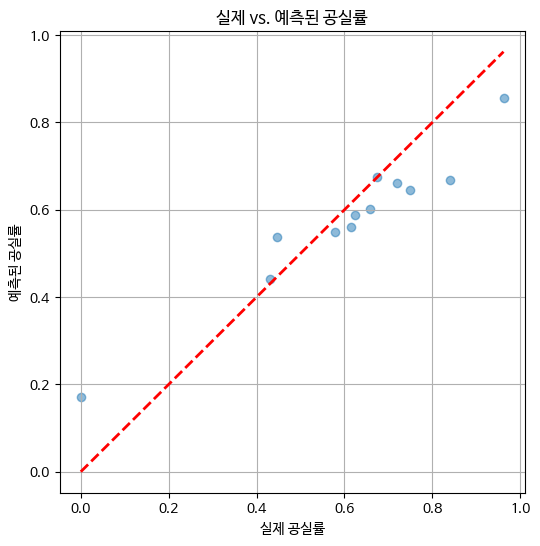

In [23]:
# 예측값 vs 실제값 시각화
plt.figure(figsize=(6,6))
plt.scatter(y_test, stacking_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel("실제 공실률")
plt.ylabel("예측된 공실률")
plt.title("실제 vs. 예측된 공실률")
plt.grid(True)
plt.show()

In [17]:
# MSE, RMSE 계산
mse = np.mean((y_test - stacking_pred) ** 2)
rmse = np.sqrt(mse)

(train_r2, test_r2, mse, rmse)

(np.float64(0.8823773680388726),
 np.float64(0.8432894730596454),
 np.float64(0.008453213503065646),
 np.float64(0.09194135904513075))

In [12]:
# 전처리된 데이터 저장
gdf_industrial.to_csv("/content/전처리 데이터.csv", encoding="utf-8-sig", index=False)

In [14]:
# 상관관계 분석 결과 저장
correlation_results = {
    "bus_distance_vs_vacancy": bus_corr,
    "subway_distance_vs_vacancy": subway_corr,
    "business_changes_vs_vacancy": business_corr,
    "land_value_vs_vacancy": land_corr
}
pd.DataFrame([correlation_results]).to_csv("/content/상관관계 분석 데이터.csv", encoding="utf-8-sig", index=False)


In [24]:
# 📂 시각화 저장 경로 설정
visualization_path = "/content/시각화 데이터"
os.makedirs(visualization_path, exist_ok=True)

# ✅ 버스 정류장 거리 vs 공실률
plt.figure(figsize=(6,6))
sns.regplot(x=gdf_industrial["bus_distance_km"], y=gdf_industrial["vacancy_rate"])
plt.title("버스 정류장 거리 vs 공실률")
plt.xlabel("버스 정류장까지 거리 (km)")
plt.ylabel("공실률")
plt.savefig(f"{visualization_path}/버스 정류장 거리 vs 공실률.png")
plt.close()

# ✅ 지하철역 거리 vs 공실률
plt.figure(figsize=(6,6))
sns.regplot(x=gdf_industrial["subway_distance_km"], y=gdf_industrial["vacancy_rate"])
plt.title("지하철역 거리 vs 공실률")
plt.xlabel("지하철역까지 거리 (km)")
plt.ylabel("공실률")
plt.savefig(f"{visualization_path}/지하철역 거리 vs 공실률.png")
plt.close()

# ✅ 상권 변화 횟수 vs 공실률
plt.figure(figsize=(6,6))
sns.regplot(x=gdf_industrial["num_business_changes"], y=gdf_industrial["vacancy_rate"])
plt.title("상권 변화 횟수 vs 공실률")
plt.xlabel("상권 변화 횟수")
plt.ylabel("공실률")
plt.savefig(f"{visualization_path}/상권 변화 횟수 vs 공실률.png")
plt.close()

# ✅ 개별공시지가 vs 공실률
plt.figure(figsize=(6,6))
sns.regplot(x=gdf_industrial["land_value"], y=gdf_industrial["vacancy_rate"])
plt.title("개별공시지가 vs 공실률")
plt.xlabel("개별공시지가")
plt.ylabel("공실률")
plt.savefig(f"{visualization_path}/개별공시지가 vs 공실률.png")
plt.close()

# ✅ 예측값 vs 실제값 (모델 성능 평가)
plt.figure(figsize=(6,6))
plt.scatter(y_test, stacking_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel("실제 공실률")
plt.ylabel("예측된 공실률")
plt.title("실제 vs. 예측된 공실률")
plt.grid(True)
plt.savefig(f"{visualization_path}/실제 vs. 예측된 공실률.png")
plt.close()

<ipython-input-24-cddc0d227a72>:38: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumBarunGothic.
  plt.savefig(f"{visualization_path}/개별공시지가 vs 공실률.png")


In [25]:
# 모델 평가 결과 저장
results_df = pd.DataFrame({
    "train_r2": [train_r2],
    "test_r2": [test_r2],
    "mse": [mse],
    "rmse": [rmse]
})
results_df.to_csv("/content/모델 평가 데이터.csv", encoding="utf-8-sig", index=False)